# Goal: create a Hybrid image

## Hybrid Images.

A hybrid image is the sum of a low-pass filtered version of the one image and a high-pass filtered version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the "cutoff-frequency". In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. 

Import library

In [1]:
import cv2
import numpy as np
from IPython.display import Image, display

Fourier fuction

In [2]:
def fourier_img(img, kernel):
    # Compute convolution between `img` and `kernel` using numpy's FFT.
    # Load the image.
    image = cv2.imread(img)
    # Get size of image and kernel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    # Apply padding to the kernel.
    padded_kernel = np.zeros(image.shape[:2])
    start_h = (image_h - kernel_h) // 2
    start_w = (image_w - kernel_w) // 2
    padded_kernel[start_h : start_h + kernel_h, start_w : start_w + kernel_w] = kernel
    # Create image to write to.
    output = np.zeros(image.shape)
    # Run FFT on all 3 channels.
    for colour in range(3):
        Fi = np.fft.fft2(image[:, :, colour])
        Fk = np.fft.fft2(padded_kernel)
        # Inverse fourier.
        output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255

    # Return the result of convolution.
    return output

Convolution function

In [3]:
def convolution(img, kernel):
    # This function executes the convolution between `img` and `kernel`.
    print("[{}]\tRunning convolution...\n".format(img))
    # Load the image.
    image = cv2.imread(img)
    # Flip template before convolution.
    kernel = cv2.flip(kernel, -1)
    # Get size of image and kernel. 3rd value of shape is colour channel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    (pad_h, pad_w) = (kernel_h // 2, kernel_w // 2)
    # Create image to write to.
    output = np.zeros(image.shape)
    # Slide kernel across every pixel.
    for y in range(pad_h, image_h - pad_h):
        for x in range(pad_w, image_w - pad_w):
            # If coloured, loop for colours.
            for colour in range(image.shape[2]):
                # Get center pixel.
                center = image[
                    y - pad_h : y + pad_h + 1, x - pad_w : x + pad_w + 1, colour
                ]
                # Perform convolution and map value to [0, 255].
                # Write back value to output image.
                output[y, x, colour] = (center * kernel).sum() / 255

    # Return the result of the convolution.
    return output

Guassian blur function

In [4]:
def gaussian_blur(image, sigma, fourier):
    # Builds a Gaussian kernel used to perform the LPF on an image.
    # fourier: either true or false, If true use fourier, otherwise use convolution function
    print("[{}]\tCalculating Gaussian kernel...".format(image))

    # Calculate size of filter.
    size = 8 * sigma + 1
    if not size % 2:
        size = size + 1

    center = size // 2
    kernel = np.zeros((size, size))

    # Generate Gaussian blur.
    for y in range(size):
        for x in range(size):
            diff = (y - center) ** 2 + (x - center) ** 2
            kernel[y, x] = np.exp(-diff / (2 * sigma ** 2))

    kernel = kernel / np.sum(kernel)

    if fourier:
        return fourier_img(image, kernel)
    else:
        return convolution(image, kernel)

High pass and Low pass function

In [5]:
def low_pass(image, cutoff, fourier):
    # Generate low pass filter of image.
    print("[{}]\tGenerating low pass image...".format(image))
    return gaussian_blur(image, cutoff, fourier)


def high_pass(image, cutoff, fourier):
    # Generate high pass filter of image. This is simply the image minus its low passed result.
    print("[{}]\tGenerating high pass image...".format(image))
    return (cv2.imread(image) / 255) - low_pass(image, cutoff, fourier)


Hybrid function

In [6]:
def hybrid_image(images, cutoff, fourier):
    # Create a hybrid image by summing together the low and high frequency images.
    # Perform low pass filter and export.
    low = low_pass(images[0], cutoff[0], fourier)
    # Perform high pass filter and export.
    high = high_pass(images[1], cutoff[1], fourier)

    print("Creating hybrid image...")
    return low + high

Convert to human-friendly format

In [7]:
def output_vis(image, num_of_img=1, gap_btwn_img=0):
    # Display hybrid image comparison for report. Visualisation shows 5 images 
    # reducing in size to simulate viewing the image from a distance.
    print("Creating visualisation...")

    num = num_of_img    # Number of images to display.
    gap = gap_btwn_img  # Gap between images (px).

    # Create list of images.
    image_list = [image]
    max_height = image.shape[0]
    max_width = image.shape[1]

    # Add images to list and increase max width.
    for i in range(1, num):
        tmp = cv2.resize(image, (0, 0), fx=0.5 ** i, fy=0.5 ** i)
        max_width += tmp.shape[1] + gap
        image_list.append(tmp)

    # Create space for image stack.
    stack = np.ones((max_height, max_width, 3)) * 255

    # Add images to stack.
    current_x = 0
    for img in image_list:
        stack[
            max_height - img.shape[0] :, current_x : img.shape[1] + current_x, :
        ] = img
        current_x += img.shape[1] + gap

    return stack


Load Image

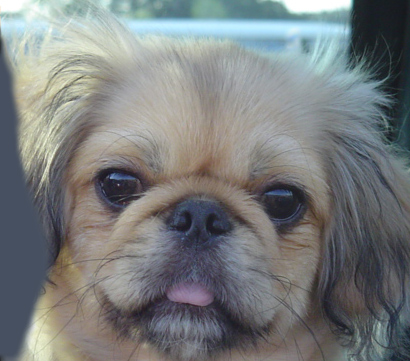

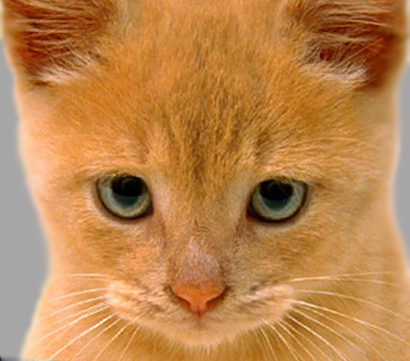

In [8]:
dog_img = 'dog.jpg'
cat_img = 'cat.jpg'
dog = cv2.imread(dog_img)
cat = cv2.imread(cat_img)

dogImg = Image(filename=dog_img)
catImg = Image(filename=cat_img)
display(dogImg)
display(catImg)

Create hybrid image

In [9]:
hybrid = hybrid_image([dog_img, cat_img], [7, 7], True)
print(hybrid)
visual_hybrid = output_vis(hybrid) * 255

[dog.jpg]	Generating low pass image...
[dog.jpg]	Calculating Gaussian kernel...
[cat.jpg]	Generating high pass image...
[cat.jpg]	Generating low pass image...
[cat.jpg]	Calculating Gaussian kernel...
Creating hybrid image...
[[[ 0.57831052  0.60766768  0.57214197]
  [ 0.5133728   0.57841289  0.563919  ]
  [ 0.44488346  0.53338728  0.55476046]
  ...
  [ 0.58261165  0.51041621  0.45794521]
  [ 0.69657099  0.59841997  0.52227777]
  [ 0.75024997  0.65721859  0.5723706 ]]

 [[ 0.66575248  0.6642607   0.6263234 ]
  [ 0.59633715  0.6298041   0.61183053]
  [ 0.5233751   0.58351848  0.59249327]
  ...
  [ 0.60189514  0.52838728  0.47251684]
  [ 0.70700605  0.61472193  0.53426893]
  [ 0.77558296  0.67595325  0.59365288]]

 [[ 0.75116154  0.71885317  0.66271595]
  [ 0.68088214  0.68284673  0.64956014]
  [ 0.59530375  0.62719451  0.62766103]
  ...
  [ 0.62004704  0.54906827  0.481782  ]
  [ 0.71994108  0.63740131  0.54856107]
  [ 0.7952702   0.70080057  0.60915208]]

 ...

 [[ 0.24212002  0.057731 

/home/lam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Show hybrid image and save file

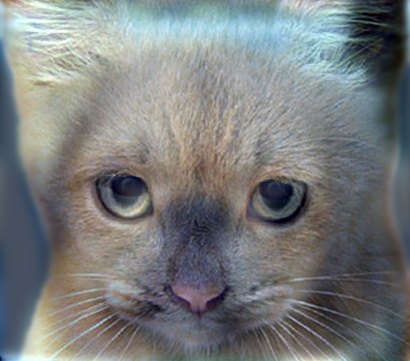

In [10]:
cv2.imwrite('hybrid_cat_dog.jpg', visual_hybrid)
Image(filename='hybrid_cat_dog.jpg')